# Task 3: Air Pollution Forecasting — Project Overview

This project focuses on building and evaluating a recurrent neural network (RNN) model for analyzing time series data describing air pollution (PM2.5) in Beijing during 2013–2017.  
The goal is to forecast PM2.5 concentration based on meteorological data from the Wanshouxigong monitoring station.

Project steps include:

- Loading, cleaning, and exploring the CSV dataset
- Preparing data for time series analysis (sequential split, standardization, TimeseriesGenerator)
- Building and training an LSTM (Long Short-Term Memory) model
- Evaluating prediction quality using regression metrics (MSE, R²)
- Visualizing results and interpreting the model.


In [8]:
## Import required libraries

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Load data from CSV, dropping columns 'No', 'wd', 'station'
file_path = 'PRSA_Data_Wanshouxigong_20130301-20170228.csv'
columns_to_drop = ['No', 'wd', 'station']
try:
    df = pd.read_csv(file_path)
    print("File loaded successfully.")
    df.drop(columns=columns_to_drop, inplace=True)
    print("Columns 'No', 'wd', 'station' have been dropped.\n")
    print("First 5 rows of the original data:")
    print(df.head())
except FileNotFoundError:
    print(f"File {file_path} not found.")
    df = None

# Combine 'year', 'month', 'day', 'hour' into a single datetime column
if df is not None:
    df['Date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    print("\nColumn 'Date' has been created.")

    # Drop the original 'year', 'month', 'day', 'hour' columns
    df.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
    
    # Set 'Date' as the DataFrame index
    df.set_index('Date', inplace=True)
    print("Set 'Date' as DataFrame index.\n")
    print("Transformed data structure:")
    print(df.info())

    # Show first 5 rows of transformed data
    print("\nFirst 5 rows of transformed data:")
    print(df.head())


File loaded successfully.
Columns 'No', 'wd', 'station' have been dropped.

First 5 rows of the original data:
   year  month  day  hour  PM2.5  PM10  SO2   NO2     CO    O3  TEMP    PRES  \
0  2013      3    1     0    9.0   9.0  6.0  17.0  200.0  62.0   0.3  1021.9   
1  2013      3    1     1   11.0  11.0  7.0  14.0  200.0  66.0  -0.1  1022.4   
2  2013      3    1     2    8.0   8.0  NaN  16.0  200.0  59.0  -0.6  1022.6   
3  2013      3    1     3    8.0   8.0  3.0  16.0    NaN   NaN  -0.7  1023.5   
4  2013      3    1     4    8.0   8.0  3.0   NaN  300.0  36.0  -0.9  1024.1   

   DEWP  RAIN  WSPM  
0 -19.0   0.0   2.0  
1 -19.3   0.0   4.4  
2 -19.7   0.0   4.7  
3 -20.9   0.0   2.6  
4 -21.7   0.0   2.5  

Column 'Date' has been created.
Set 'Date' as DataFrame index.

Transformed data structure:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
--

### Interpretation of Remaining Columns

After preprocessing, our DataFrame `df` contains a time-based index and columns representing pollutant concentrations and meteorological conditions. These variables form the foundation for building a predictive model.

Below is a brief description of each variable.

#### Target Variable (Prediction Target)

* **`PM2.5`**: Concentration of fine particulate matter less than 2.5 microns in diameter (µg/m³). This is the main air pollution indicator, harmful to health. **This is the value we aim to forecast.**

#### Explanatory Variables (Features)

The features can be divided into two logical groups: other pollutants (often correlated with PM2.5) and meteorological variables (which affect formation, dispersal, and removal of pollutants).

**1. Other Pollutants:**

* **`PM10`**: Particulate matter <10 microns (µg/m³), includes PM2.5 fraction; strongly correlated.
* **`SO2`**: Sulfur dioxide concentration (µg/m³).
* **`NO2`**: Nitrogen dioxide concentration (µg/m³).
* **`CO`**: Carbon monoxide concentration (µg/m³).
* **`O3`**: Ozone concentration (µg/m³).

Gases like `SO2` and `NO2` can lead to the formation of secondary particulate matter (including PM2.5) through atmospheric reactions.

**2. Meteorological Variables:**

* **`TEMP`**: Temperature (°C). Affects reaction rates and air mixing.
* **`PRES`**: Atmospheric pressure (hPa). High pressure is linked to stable conditions, often resulting in pollutant accumulation.
* **`DEWP`**: Dew point temperature (°C). Indicates air humidity; high humidity can promote condensation of pollutants and aerosol formation.
* **`RAIN`**: Precipitation (mm). Rain cleanses the air by washing out particulates and pollutants.

#### Observations & Next Steps

Inspection of the data structure (`df.info()`) shows that **missing values (`NaN`)** exist in several columns, including our target **`PM2.5`**. This is critical, as most machine learning algorithms cannot operate on incomplete data. In the next steps, we’ll need to handle this issue, likely through row removal or imputation techniques such as interpolation.


In [11]:
# Displaying descriptive statistics
print("Descriptive statistics for the dataset:")
df.describe().round(2)


Descriptive statistics for the dataset:


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,34368.00,34580.00,34395.00,34310.00,33767.00,33986.00,35045.00,35045.00,35045.00,35045.00,35051.00
mean,85.02,112.22,17.15,55.53,1370.40,56.23,13.78,1011.51,2.71,0.06,1.75
std,85.98,97.59,23.94,35.81,1223.14,57.08,11.39,10.57,13.70,0.80,1.21
min,3.00,2.00,0.29,2.00,100.00,0.21,-16.80,985.10,-35.30,0.00,0.00
25%,23.00,39.00,3.00,28.00,600.00,8.00,3.40,1002.80,-8.50,0.00,0.90
50%,60.00,91.00,8.00,49.00,1000.00,42.00,14.80,1011.00,3.30,0.00,1.40
75%,116.00,154.00,21.00,77.00,1700.00,82.00,23.50,1020.00,15.20,0.00,2.30
max,999.00,961.00,411.00,251.00,9800.00,358.00,40.60,1042.00,28.50,46.40,13.20


The `count` value confirms that there are missing data in the columns PM2.5, PM10, SO2, NO2, CO, and O3.


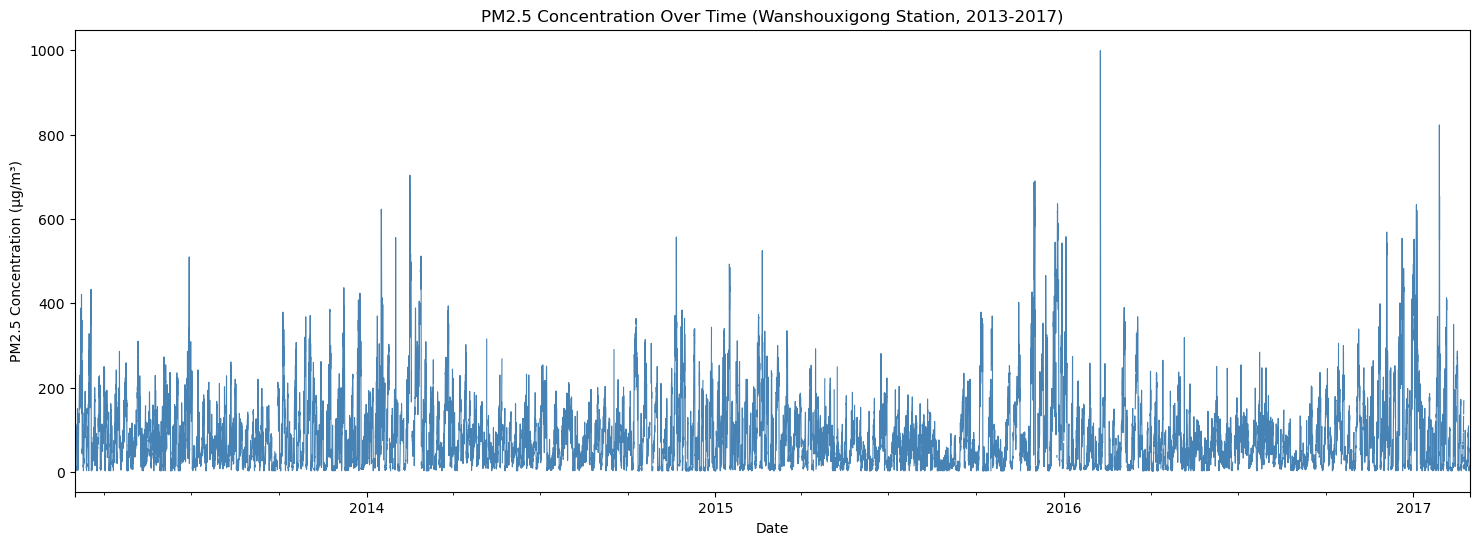

In [12]:
# Plotting PM2.5 values over time
plt.figure(figsize=(18, 6))
df['PM2.5'].plot(title='PM2.5 Concentration Over Time (Wanshouxigong Station, 2013-2017)',
                 xlabel='Date',
                 ylabel='PM2.5 Concentration (µg/m³)',
                 color='steelblue',
                 linewidth=0.8)
plt.show()


We observe a cyclical annual pattern. PM2.5 concentrations are consistently higher in the winter months (October-March).


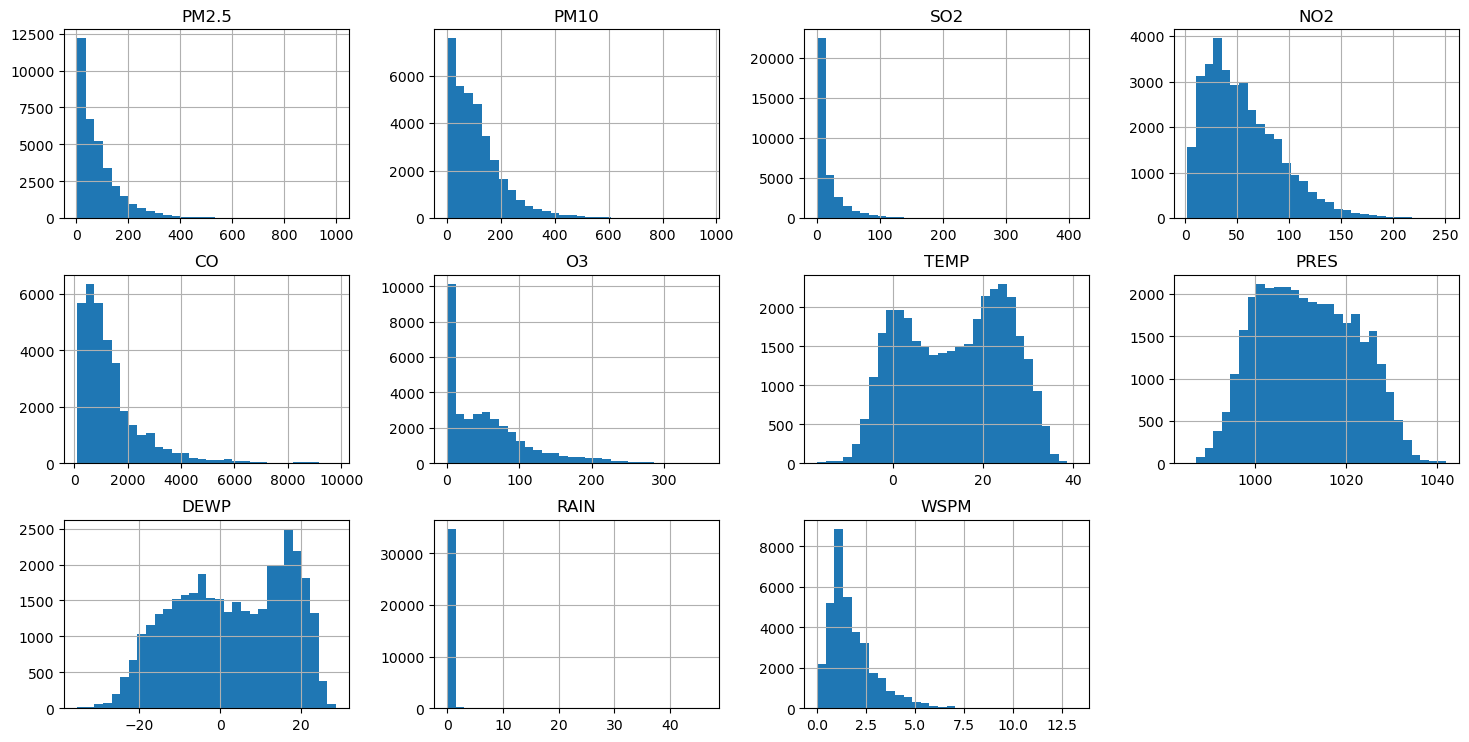

In [13]:
# Generating histograms for all variables in the dataset
df.hist(bins=30, figsize=(18, 12), layout=(4, 4))
plt.show()


#### Histogram Interpretation

* **Pollutants (`PM2.5`, `PM10`, `SO2`, `NO2`, `CO`)**: All these variables have strongly **right-skewed distributions**. Most observations are concentrated at low values, with a long "tail" to the right, representing rare but extreme pollution episodes. This skewness may be problematic for some models, suggesting the need for a transformation (e.g., logarithmic) at a later stage.
* **`RAIN`**: The distribution is extremely skewed, with an overwhelming majority of values equal to 0.
* **Meteorological variables (`TEMP`, `PRES`, `DEWP`)**: Their distributions are much more symmetric and close to a normal distribution, which is typical for this type of data.


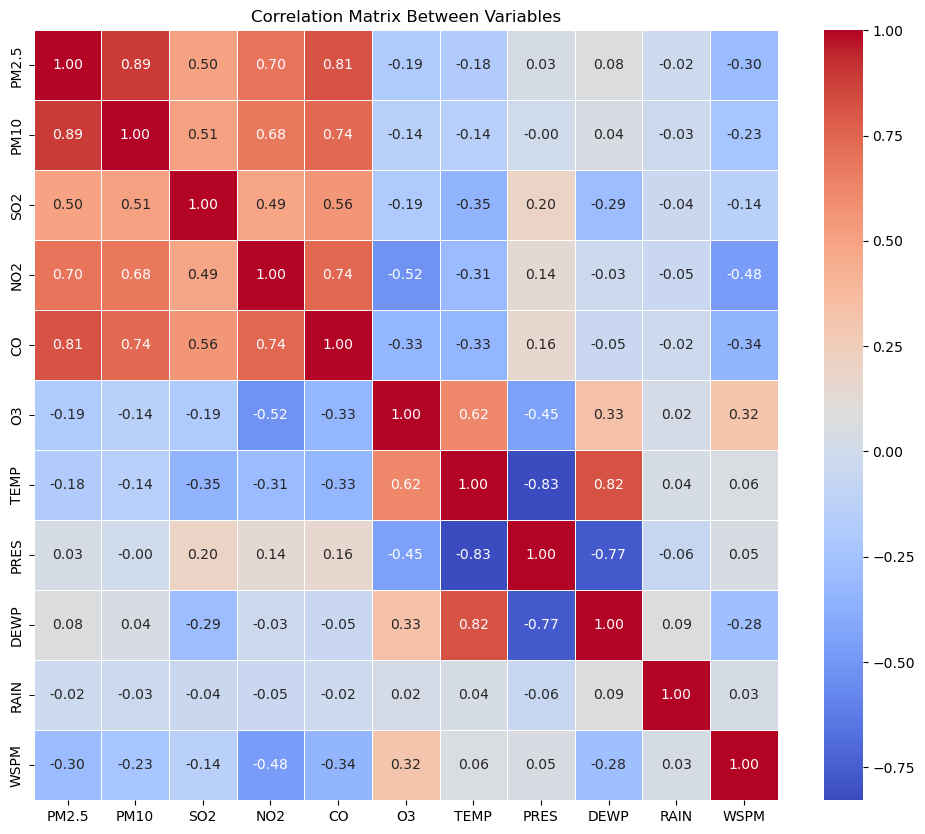

In [14]:
# Calculating the correlation matrix
corr_matrix = df.corr()

# Visualizing the correlation matrix with a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Between Variables')
plt.show()


#### Correlation Matrix Interpretation

The heatmap shows Pearson correlation coefficients (from -1 to 1). Values close to 1 (red color) indicate a strong positive correlation, while values close to -1 (blue color) indicate a strong negative correlation.

* **`PM2.5` and other pollutants**:
    * Very strong positive correlation with `PM10` (**0.88**), which is logical since `PM2.5` is a subset of `PM10`.
    * Strong correlation with `CO` (**0.79**) and `NO2` (**0.68**), indicating common emission sources (e.g., fuel combustion).
    * Moderate correlation with `SO2` (**0.47**).

* **`PM2.5` and meteorological variables**:
    * Weak negative correlation with `TEMP` (**-0.10**). This confirms the seasonal observation – lower temperatures (winter) are associated with higher `PM2.5` concentrations.
    * Weak positive correlation with `DEWP` (**0.18**) and almost none with `PRES` (**0.01**).
    * Very weak negative correlation with `RAIN` (**-0.05**), suggesting that rain has a minimal linear impact on air "cleaning", although its role may be more complex.

* **Multicollinearity**: There are strong correlations between explanatory variables themselves, e.g., `TEMP` and `DEWP` (**0.82**), which is natural. This is important when selecting models (e.g., it may be a problem for linear models, but less so for tree-based models).


In [15]:
# Creating a copy of the DataFrame
df_processed = df.copy()

print(f"Initial number of rows: {len(df_processed)}")
print("Number of missing values in each column:")
print(df_processed.isnull().sum())
print("-" * 50)


# Removing rows with missing target values
print("\nRemoving rows where PM2.5 is NaN")
rows_before = len(df_processed)
df_processed.dropna(subset=['PM2.5'], inplace=True)
rows_after = len(df_processed)

print(f"Number of rows before removal: {rows_before}")
print(f"Number of rows after removal:   {rows_after}")
print(f"Removed {rows_before - rows_after} rows.")

print("\nNumber of missing values AFTER removing rows with NaN in PM2.5:")
remaining_nans = df_processed.isnull().sum()
# Display only columns where missing values still exist
print(remaining_nans[remaining_nans > 0])
print("-" * 50)

# Filling missing values in other columns
print("We will fill the missing values using interpolation")

# Finding the first row where, for example, the 'SO2' column has missing data
try:
    first_nan_index = df_processed[df_processed['SO2'].isnull()].index[0]

    print(f"\nExample: Data fragment around the first gap in 'SO2' (index: {first_nan_index})")
    print("\nBEFORE interpolation:")
    # Display the row with the missing value and its neighboring rows
    example_slice_before = df_processed.loc[first_nan_index - pd.Timedelta(hours=1) : first_nan_index + pd.Timedelta(hours=1)]
    print(example_slice_before)

    # Performing interpolation on the entire DataFrame
    df_processed.interpolate(method='linear', inplace=True)

    print("\nAFTER interpolation:")
    example_slice_after = df_processed.loc[first_nan_index - pd.Timedelta(hours=1) : first_nan_index + pd.Timedelta(hours=1)]
    print(example_slice_after)

except IndexError:
    print("No missing values found in 'SO2' for demonstration")
print("-" * 50)

print("\nFinal verification")
# Interpolation may not have worked at the very beginning of the dataset if there were missing values there.
# We remove such rows if they exist.
if df_processed.isnull().values.any():
    print("Detected and removed missing values at the very beginning of the dataset.")
    df_processed.dropna(inplace=True)

print("Final number of missing values in the entire dataset:")
print(df_processed.isnull().sum())
print(f"\nFinal number of rows for further analysis: {len(df_processed)}")


Initial number of rows: 35064
Number of missing values in each column:
PM2.5     696
PM10      484
SO2       669
NO2       754
CO       1297
O3       1078
TEMP       19
PRES       19
DEWP       19
RAIN       19
WSPM       13
dtype: int64
--------------------------------------------------

Removing rows where PM2.5 is NaN
Number of rows before removal: 35064
Number of rows after removal:   34368
Removed 696 rows.

Number of missing values AFTER removing rows with NaN in PM2.5:
PM10     17
SO2     242
NO2     331
CO      872
O3      686
TEMP     19
PRES     19
DEWP     19
RAIN     19
WSPM     13
dtype: int64
--------------------------------------------------
We will fill the missing values using interpolation

Example: Data fragment around the first gap in 'SO2' (index: 2013-03-01 02:00:00)

BEFORE interpolation:
                     PM2.5  PM10  SO2   NO2     CO    O3  TEMP    PRES  DEWP  \
Date                                                                           
2013-03-01 01:00: